In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# LDA

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Preparation

In [23]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [124]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [125]:
from nltk.corpus import wordnet

## Get Data

In [126]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

es = Elasticsearch(
    [{'host': 'localhost', 'port': 9200}], timeout=30, max_retries=10, retry_on_timeout=True
)

In [127]:
res = es.search(index = "ir_full", body = {"query": {"match": {"content" : "bayesian"}}}, size = 20)
# res = es.search(index = "ir_full", body = {"query": {"match_phrase": {"authors" : "alessandro bozzon"}}}, size = 10)

data = []

print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print(hit['_id'], hit['_source']['title'])
    print(hit['_source']['journal'])
    data.append(hit['_source']['content'])

Got 1537 Hits:
journals_ml_SchulteQKYS16 Fast learning of relational dependency networks.
Machine Learning
journals_ml_WatanabeSW09 Upper bound for variational free energy of Bayesian networks.
Machine Learning
journals_ml_ZhengW00 Lazy Learning of Bayesian Rules.
Machine Learning
conf_icra_DiardBM04 A Theoretical Comparison of Probabilistic and Biomimetic Models of Mobile Robot Navigation.
ICRA
conf_icra_DiardBM04a Hierarchies of Probabilistic Models of Navigation: the Bayesian Map and the Abstraction Operator.
ICRA
journals_ml_DomingosP97 On the Optimality of the Simple Bayesian Classifier under Zero-One Loss.
Machine Learning
conf_sigir_ChaiCN02 Bayesian online classifiers for text classification and filtering.
SIGIR
journals_ml_NorenO05 Case Based Imprecision Estimates for Bayes Classifiers with the Bayesian Bootstrap.
Machine Learning
journals_jmlr_LeeC04 Lossless Online Bayesian Bagging.
Journal of Machine Learning Research
journals_ml_RosmanHR16 Bayesian policy reuse.
Machine Le

## Process

In [128]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [129]:
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.5/dist-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [130]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def remove_commons(texts):
    return [[word for word in simple_preprocess(str(doc)) if not wordnet.synsets(word)] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [131]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# data_words_nostops = remove_commons(data_words_nostop)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv

# data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ'])
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [132]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [122]:
for x in range(7, 14, 2):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=x, random_state=100,
                                               update_every=1, chunksize=250, passes=10, alpha='auto', per_word_topics=True)

    doc_lda = lda_model[corpus]
    print(x, 'topics')
    # Compute Perplexity
    print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)
    print('')

7 topics
Perplexity:  -6.6107245398940035
Coherence Score:  0.4359494084204985

9 topics
Perplexity:  -6.551751831997734
Coherence Score:  0.48339810896528296

11 topics
Perplexity:  -6.60485575272505
Coherence Score:  0.33404597624373084

13 topics
Perplexity:  -6.564691101593709
Coherence Score:  0.3995623972069167



In [134]:
for x in range(9, 16, 2):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=x, random_state=100,
                                               update_every=1, chunksize=250, passes=10, alpha='auto', per_word_topics=True)

    doc_lda = lda_model[corpus]
    print(x, 'topics')
    # Compute Perplexity
    print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)
    print('')

9 topics
Perplexity:  -6.876400059831324
Coherence Score:  0.4100420902448275

11 topics
Perplexity:  -6.892241704086851
Coherence Score:  0.41876183506825354

13 topics
Perplexity:  -6.8460735041939165
Coherence Score:  0.5016286880013856

15 topics
Perplexity:  -6.938811290517259
Coherence Score:  0.40478372959212755




## Models

In [135]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=13, random_state=100,
                                           update_every=1, chunksize=250, passes=10, alpha='auto', per_word_topics=True)

doc_lda = lda_model[corpus]
pprint(lda_model.print_topics())

[(0,
  '0.001*"bayesian" + 0.001*"model" + 0.001*"network" + 0.001*"use" + '
  '0.001*"algorithm" + 0.001*"policy" + 0.001*"task" + 0.001*"edge" + '
  '0.001*"set" + 0.001*"number"'),
 (1,
  '0.028*"edge" + 0.019*"network" + 0.019*"operator" + 0.018*"search" + '
  '0.018*"score" + 0.014*"bayesian" + 0.013*"graph" + 0.011*"order" + '
  '0.011*"essential_graph" + 0.009*"space"'),
 (2,
  '0.039*"bayesian" + 0.029*"lbr" + 0.020*"domain" + 0.013*"attribute" + '
  '0.013*"naive" + 0.013*"classifier" + 0.012*"algorithm" + 0.012*"rule" + '
  '0.011*"value" + 0.011*"use"'),
 (3,
  '0.027*"network" + 0.017*"learn" + 0.016*"set" + 0.014*"datum" + '
  '0.014*"edge" + 0.014*"task" + 0.013*"bayesian" + 0.012*"bias" + '
  '0.011*"structure" + 0.011*"order"'),
 (4,
  '0.034*"document" + 0.016*"bayesian" + 0.013*"use" + 0.011*"feature" + '
  '0.011*"set" + 0.011*"distance" + 0.010*"model" + 0.009*"measure" + '
  '0.009*"logistic_regression" + 0.009*"algorithm"'),
 (5,
  '0.024*"landmark" + 0.013*"posit

------------ TESTING TF-IDF ------------

In [70]:
tfidf_model = gensim.models.TfidfModel(corpus, id2word=id2word)

tfidf_lda_model = gensim.models.ldamodel.LdaModel(tfidf_model[corpus], id2word=id2word, num_topics=26, random_state=100,
                                           update_every=1, chunksize=250, passes=10, alpha='auto', per_word_topics=True)
pprint(tfidf_lda_model.print_topics())

[(24,
  '0.000*"binary" + 0.000*"unlikely" + 0.000*"composition" + 0.000*"composite" '
  '+ 0.000*"composer" + 0.000*"compiler" + 0.000*"compile" + 0.000*"broker" + '
  '0.000*"connection" + 0.000*"strand"'),
 (2,
  '0.003*"ilp" + 0.002*"chapter" + 0.002*"learner" + 0.001*"attribute_value" + '
  '0.001*"golem" + 0.001*"linus" + 0.001*"clause" + 0.001*"foil" + '
  '0.001*"empirical" + 0.001*"attribute"'),
 (17,
  '0.002*"finger" + 0.002*"underactuated" + 0.002*"wire" + 0.001*"slider" + '
  '0.001*"prosthetic" + 0.001*"spring" + 0.001*"adaptive_grasp" + 0.001*"fig" '
  '+ 0.001*"transmission" + 0.001*"compression"'),
 (16,
  '0.004*"psp" + 0.002*"engineer" + 0.002*"transducer" + 0.002*"noise" + '
  '0.001*"damping" + 0.001*"echo" + 0.001*"equilibrium" + 0.001*"ohm" + '
  '0.001*"active" + 0.001*"corporation"'),
 (15,
  '0.003*"cleanroom" + 0.003*"workshop" + 0.002*"mode" + 0.002*"trust" + '
  '0.002*"autonomy" + 0.002*"confidence" + 0.002*"run" + 0.001*"tm" + '
  '0.001*"indicator" + 0.0

------------ TESTING TF-IDF ------------

In [136]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.8460735041939165

Coherence Score:  0.5016286880013856


In [137]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
12     18.060694        1       1  0.091865  0.001198
2      16.645138        1       2  0.141025  0.046059
7      12.230351        1       3 -0.003777  0.086504
10     11.993257        1       4  0.122075  0.054810
8       9.760810        1       5  0.102899 -0.102187
4       7.544026        1       6  0.037052  0.134133
3       7.017731        1       7  0.077475 -0.045308
1       4.260303        1       8  0.003632 -0.190268
6       3.956358        1       9 -0.100245 -0.025983
5       3.761429        1      10 -0.107009 -0.001640
9       2.670942        1      11 -0.132295 -0.039850
11      2.097110        1      12 -0.134792  0.086620
0       0.001862        1      13 -0.097905 -0.004088, topic_info=     Category        Freq                Term       Total  loglift  logprob
term                                                                       
2843  Default  112.000000                 lbr  112.000000  30.0000  30.0000
2530  Default   93.000000              policy   93.000000  29.0000  29.0000
71    Default  235.000000             network  235.000000  28.0000  28.0000
1887  Default   59.000000            document   59.000000  27.0000  27.0000
2594  Default   90.000000                edge   90.000000  26.0000  26.0000
1119  Default  212.000000               model  212.000000  25.0000  25.0000
566   Default  146.000000          classifier  146.000000  24.0000  24.0000
1644  Default   56.000000                 map   56.000000  23.0000  23.0000
1729  Default  102.000000           attribute  102.000000  22.0000  22.0000
229   Default  102.000000                task  102.000000  21.0000  21.0000
791   Default   96.000000            variable   96.000000  20.0000  20.0000
307   Default  102.000000               class  102.000000  19.0000  19.0000
1388  Default  112.000000              domain  112.000000  18.0000  18.0000
2650  Default   26.000000                user   26.000000  17.0000  17.0000
1265  Default   53.000000               naive   53.000000  16.0000  16.0000
2188  Default   38.000000          relational   38.000000  15.0000  15.0000
2484  Default   35.000000  dependency_network   35.000000  14.0000  14.0000
1393  Default   37.000000              signal   37.000000  13.0000  13.0000
1770  Default   63.000000              parent   63.000000  12.0000  12.0000
1522  Default   21.000000            landmark   21.000000  11.0000  11.0000
1163  Default   40.000000              belief   40.000000  10.0000  10.0000
1078  Default   36.000000               score   36.000000   9.0000   9.0000
2721  Default   51.000000                type   51.000000   8.0000   8.0000
2178  Default   35.000000              search   35.000000   7.0000   7.0000
230   Default   35.000000               robot   35.000000   6.0000   6.0000
2049  Default   32.000000               agent   32.000000   5.0000   5.0000
253   Default   82.000000           structure   82.000000   4.0000   4.0000
2481  Default   59.000000                node   59.000000   3.0000   3.0000
862   Default   82.000000         performance   82.000000   2.0000   2.0000
1171  Default   32.000000              matrix   32.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
2174  Topic13    0.000305              number  110.389595  -1.9066  -7.2471
693   Topic13    0.000142             serious    1.597854   1.5633  -8.0125
84    Topic13    0.000142           viewpoint    1.597832   1.5632  -8.0127
1024  Topic13    0.000319                 set  153.904297  -2.1958  -7.2039
1163  Topic13    0.000249              belief   40.010597  -1.0946  -7.4500
1653  Topic13    0.000267               space   65.079651  -1.5121  -7.3810
345   Topic13    0.000249         observation   53.978348  -1.3935  -7.4494
136   Topic13    0.000246               order   55.911865  -1.4436  -7.4643
1541  Topic13    0.000142      

In [36]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [37]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('research', 0.06320400500625782),
   ('system', 0.026282853566958697),
   ('area', 0.025031289111389236),
   ('scm', 0.02127659574468085),
   ('activity', 0.018147684605757195),
   ('time', 0.016896120150187734),
   ('part', 0.015018773466833541),
   ('current', 0.014392991239048811),
   ('knowledge', 0.013141426783479349),
   ('large', 0.012515644555694618)]),
 (1,
  [('research', 0.09121395036887994),
   ('information', 0.04225352112676056),
   ('participant', 0.03621730382293763),
   ('paper', 0.030181086519114688),
   ('problem', 0.021462105969148222),
   ('process', 0.021462105969148222),
   ('method', 0.02079141515761234),
   ('web', 0.02012072434607646),
   ('study', 0.01676727028839705),
   ('user', 0.01676727028839705)]),
 (2,
  [('research', 0.06574827802128992),
   ('researcher', 0.058860363180964305),
   ('datum', 0.05385097056981841),
   ('service', 0.02567313713212273),
   ('management', 0.022542266750156543),
   ('result', 0.015654351909830933),
   ('robodoc', 0

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [50]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

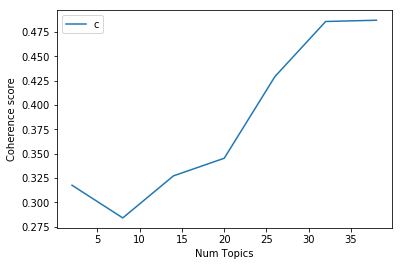

In [51]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3176
Num Topics = 8  has Coherence Value of 0.2841
Num Topics = 14  has Coherence Value of 0.3273
Num Topics = 20  has Coherence Value of 0.3453
Num Topics = 26  has Coherence Value of 0.4292
Num Topics = 32  has Coherence Value of 0.4856
Num Topics = 38  has Coherence Value of 0.4869


In [42]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.071*"area" + 0.064*"center" + 0.048*"activity" + 0.039*"student" + '
  '0.032*"faculty" + 0.029*"interest" + 0.026*"consortium" + 0.026*"member" + '
  '0.026*"cefriel" + 0.023*"local"'),
 (1,
  '0.085*"robot" + 0.055*"technology" + 0.048*"application" + 0.043*"robotic" '
  '+ 0.043*"sensor" + 0.022*"driver" + 0.022*"industrial_robot" + '
  '0.022*"future" + 0.021*"cost" + 0.021*"intelligence"'),
 (2,
  '0.089*"project" + 0.063*"tool" + 0.063*"resource" + 0.056*"work" + '
  '0.033*"support" + 0.033*"collection" + 0.030*"individual" + '
  '0.026*"scholarly" + 0.023*"bibliography" + 0.023*"element"'),
 (3,
  '0.082*"scm" + 0.048*"system" + 0.041*"change" + 0.039*"practice" + '
  '0.036*"idea" + 0.034*"basic" + 0.027*"process" + 0.024*"impact" + '
  '0.024*"current" + 0.024*"success"'),
 (4,
  '0.049*"area" + 0.046*"system" + 0.041*"category" + 0.041*"publication" + '
  '0.038*"computer" + 0.038*"current" + 0.032*"year" + 0.032*"number" + '
  '0.032*"collection" + 0.029*"document

## Dominant topic per document

In [349]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic#.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.3936,"object, rgb, image, dataset, depth, detection,...",I. INTRODUCTION \nHumans are capable of learni...
1,1,4.0,0.3008,"object, rgb, image, dataset, depth, detection,...",I. INTRODUCTION \nThe ability to quickly progr...
2,2,17.0,0.6470,"image, label, model, part, rank, object, annot...",Keywords Ranking · Image retrieval · Embedding...
3,3,3.0,0.4141,"datum, set, problem, number, section, algorith...",I. INTRODUCTION \nIn many practical situations...
4,4,17.0,0.4889,"image, label, model, part, rank, object, annot...",Introduction\nThe emergence of the web as a to...
5,5,1.0,0.7050,"model, grasp, datum, parallelism, framework, i...",INTRODUCTION\nBackgroud\nTencent provides a wi...
6,6,4.0,0.4617,"object, rgb, image, dataset, depth, detection,...",I. INTRODUCTION \nThere are many robotics appl...
7,7,1.0,0.2077,"model, grasp, datum, parallelism, framework, i...",I. INTRODUCTION \nConsider the object shown in...
8,8,9.0,0.6445,"weight, gradient, learner, size, training, mod...",I. INTRODUCTION \n Deep neural network based m...
9,9,14.0,0.5076,"base, dataset, learn, matrix, noise, binary, f...","I. INTRODUCTION \n During the past few years, ..."


## Most representative document for each topic

In [350]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4542,"query, rank, document, concept, level, photo, ...",INTRODUCTION\nRecent years have witnessed the ...
1,1.0,0.7050,"model, grasp, datum, parallelism, framework, i...",INTRODUCTION\nBackgroud\nTencent provides a wi...
2,2.0,0.5468,"sequence, active, learning, learn, algorithm, ...",I. INTRODUCTION \nIn many machine learning app...
3,3.0,0.4141,"datum, set, problem, number, section, algorith...",I. INTRODUCTION \nIn many practical situations...
4,4.0,0.6007,"object, rgb, image, dataset, depth, detection,...",I. INTRODUCTION \nThe availability of public i...
5,5.0,0.6484,"column, group, compression, matrix, run, offse...",INTRODUCTION\nData has become a ubiquitous res...
6,6.0,0.4039,"image, query, distance, point, metric, search,...",INTRODUCTION\n Keyword-based image search has ...
7,7.0,0.6478,"robot, learn, learning, group, interaction, sy...",I. INTRODUCTION \n In many of the scenarios th...
8,8.0,0.6280,"user, email, active, time, feedback, sample, l...",INTRODUCTION\nWith nearly 200 billion emails s...
9,9.0,0.6445,"weight, gradient, learner, size, training, mod...",I. INTRODUCTION \n Deep neural network based m...


## Topic distribution across documents

In [351]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"object, rgb, image, dataset, depth, detection,...",4.0,0.08
1,4.0,"object, rgb, image, dataset, depth, detection,...",3.0,0.06
2,17.0,"image, label, model, part, rank, object, annot...",3.0,0.06
3,3.0,"datum, set, problem, number, section, algorith...",1.0,0.02
4,17.0,"image, label, model, part, rank, object, annot...",8.0,0.16
5,1.0,"model, grasp, datum, parallelism, framework, i...",1.0,0.02
6,4.0,"object, rgb, image, dataset, depth, detection,...",5.0,0.10
7,1.0,"model, grasp, datum, parallelism, framework, i...",1.0,0.02
8,9.0,"weight, gradient, learner, size, training, mod...",2.0,0.04
9,14.0,"base, dataset, learn, matrix, noise, binary, f...",2.0,0.04


# Summa

https://github.com/summanlp/textrank

In [140]:
from summa import summarizer
from summa import keywords
import string
import re

regex = re.compile(".*?\((.*?)\)")


In [141]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

es = Elasticsearch(
    [{'host': 'localhost', 'port': 9200}], timeout=30, max_retries=10, retry_on_timeout=True
)

In [142]:
res = es.search(index = "ir_full", body = {"query": {"match": {"content" : "support vector machine netflix"}}}, size = 50)
res = es.search(index = "ir_full", body = {"query": {"match": {"content" : "bayesian"}}}, size = 20)
# res = es.search(index = "ir_full", body = {"query": {"match_phrase": {"authors" : "alessandro bozzon"}}}, size = 10)

data = []
titles = []

print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print(hit['_id'], hit['_source']['title'])
    print(hit['_source']['journal'])
    data.append(hit['_source']['content'])
    titles.append(hit['_source']['title'])

Got 1537 Hits:
journals_ml_SchulteQKYS16 Fast learning of relational dependency networks.
Machine Learning
journals_ml_WatanabeSW09 Upper bound for variational free energy of Bayesian networks.
Machine Learning
journals_ml_ZhengW00 Lazy Learning of Bayesian Rules.
Machine Learning
conf_icra_DiardBM04 A Theoretical Comparison of Probabilistic and Biomimetic Models of Mobile Robot Navigation.
ICRA
conf_icra_DiardBM04a Hierarchies of Probabilistic Models of Navigation: the Bayesian Map and the Abstraction Operator.
ICRA
journals_ml_DomingosP97 On the Optimality of the Simple Bayesian Classifier under Zero-One Loss.
Machine Learning
conf_sigir_ChaiCN02 Bayesian online classifiers for text classification and filtering.
SIGIR
journals_ml_NorenO05 Case Based Imprecision Estimates for Bayes Classifiers with the Bayesian Bootstrap.
Machine Learning
journals_jmlr_LeeC04 Lossless Online Bayesian Bagging.
Journal of Machine Learning Research
journals_ml_RosmanHR16 Bayesian policy reuse.
Machine Le

In [143]:
for x in range(5):
    clean1 = re.sub(r'\(.*\)', '', data[x])
    clean2 = re.sub(r'\{.*\}', '', clean1)
    clean3 = re.sub(r'\[.*\]', '', clean2)
    print(titles[x])
#     print(data[x])
#     print('Normal', summarizer.summarize(data[x], words=200, split=True))
    print('Clean', summarizer.summarize(clean3, words=200, split=True))
    words = keywords.keywords(clean3, words=15, split=True)
    print('Clean', words)
    print('-'*150)
    print('')

Fast learning of relational dependency networks.
Clean ['Closed-form model evaluation for Bayesian networks is relatively less important in the single-table case, because iterating over the rows of a single data table to evaluate a dependency network is relatively fast compared to iterating over ground random variables in the relational case, where they are stored across several tables.', 'For propositional data, converting Bayesian network parameters to dependency network parameters is simple: using the standard BN product formula for the joint distribution, solve for the local conditional probability distributions given the Bayesian network parameters .', 'computes the expected log-conditional probability for a family with child node U , when we randomly select a relevant grounding of the first-order variables in the family.', 'We introduced a relational generalization of the standard propositional BN log-linear equation for the probability of a target node conditional on an assignme

In [65]:
for x in range(10):
    clean1 = re.sub(r'\(.*\)', '', data[x])
    clean2 = re.sub(r'\{.*\}', '', clean1)
    clean3 = re.sub(r'\[.*\]', '', clean2)
    print(titles[x])
    words = keywords.keywords(data[x], words=15, split=True)
    print('Normal', words)
    words = keywords.keywords(clean3, words=15, split=True)
    print('Clean', words)
    print('')

Big Data Text Summarization for Events: A Problem Based Learning Course.
Normal ['student', 'students', 'course', 'courses', 'collections', 'collection', 'text', 'virginia', 'learning', 'learn', 'linguistics', 'linguistic', 'pbl', 'based', 'multiple', 'summarize', 'summarization', 'results', 'automatic', 'units', 'unit', 'washington']
Clean ['student', 'students', 'course', 'courses', 'text', 'collections', 'collection', 'virginia', 'learning', 'learn', 'linguistics', 'linguistic', 'based', 'summarize', 'summarization', 'results', 'units', 'unit', 'automatic', 'washington', 'multiple', 'broad']

Knowledge Bases in the Age of Big Data Analytics.
Normal ['entities', 'entity', 'knowledge', 'ned', 'data', 'harvesting', 'harvests', 'phrases', 'web', 'information', 'express', 'facts', 'expressions computational', 'spo', 'methods', 'computation', 'open', 'like']
Clean ['knowledge', 'data', 'harvesting', 'projects', 'algorithms', 'tasks', 'web', 'scale', 'facts', 'spo', 'owl', 'covering', 'lea

# LDA and NMF by Scikit

https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

In [153]:
import pyLDAvis
import pyLDAvis.sklearn

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from elasticsearch import Elasticsearch
from elasticsearch import helpers

es = Elasticsearch(
    [{'host': 'localhost', 'port': 9200}], timeout=30, max_retries=10, retry_on_timeout=True
)

In [179]:
res = es.search(index = "ir_full", body = {"query": {"match": {"content" : "neural network"}}}, size = 20)
# res = es.search(index = "ir_full", body = {"query": {"match_phrase": {"authors" : "alessandro bozzon"}}}, size = 10)

data = []
titles = []

print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print(hit['_id'], hit['_source']['title'])
    print(hit['_source']['journal'])
    data.append(hit['_source']['content'])
    titles.append(hit['_source']['title'])

Got 7635 Hits:
conf_icarcv_OnunkaBS14 Complex augmentation in autonomie EEG-Cayley neural network: Integrating bipartite-trivalent graph with Erdos-Renyi in EEG network modelling.
ICARCV
conf_icra_YamadaK05 Reaction Force Inspection System Using Neural Network Classifier.
ICRA
conf_icra_KiguchiF96 Fuzzy neural friction compensation method of robot manipulation during position/force control.
ICRA
conf_icra_AfsharM04 Neural-based Control of a Robotic Hand: Evidence for Distinct Muscle Strategies.
ICRA
conf_icarcv_ZengGHY06 Analysis of Vehicle Emissions and Prediction of Gross Emitter using Remote Sensing Data.
ICARCV
conf_icra_KiguchiF98 Robot Manipulator Hybrid Control for an Unknown Environment using Visco-Elastic Neural Networks.
ICRA
conf_icarcv_ZhangZWC08 Modeling piezoelectrically driven micro/nanopositioning systems with high operating frequency.
ICARCV
conf_vldb_LakshmiZ98 Selectivity Estimation in Extensible Databases - A Neural Network Approach.
VLDB
conf_icarcv_ZhaoW12 A neura

In [180]:
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names()

In [181]:
no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [182]:
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      54.332703        1       1 -0.049302  0.000913
4      31.120646        1       2  0.011623 -0.027552
1       9.977665        1       3  0.017970  0.012543
0       4.514994        1       4  0.011684  0.007309
3       0.053991        1       5  0.008025  0.006788, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
200   Default  89.000000      control  89.000000  30.0000  30.0000
202   Default  60.000000   controller  60.000000  29.0000  29.0000
542   Default  49.000000        model  49.000000  28.0000  28.0000
223   Default  33.000000         data  33.000000  27.0000  27.0000
718   Default  59.000000        robot  59.000000  26.0000  26.0000
848   Default  31.000000     training  31.000000  25.0000  25.0000
515   Default  34.000000  manipulator  34.000000  24.0000  24.0000
563   Default  30.000000     networks  30.000000  23.0000  23.0000
624   Default  21.000000        plant  21.000000  22.0000  22.0000
486   Default  42.000000     learning  42.000000  21.0000  21.0000
444   Default  21.000000   inspection  21.000000  20.0000  20.0000
847   Default  16.000000      trained  16.000000  19.0000  19.0000
751   Default  32.000000        shown  32.000000  18.0000  18.0000
886   Default  23.000000       vector  23.000000  17.0000  17.0000
96    Default  23.000000        based  23.000000  16.0000  16.0000
470   Default  14.000000        joint  14.000000  15.0000  15.0000
370   Default  31.000000     friction  31.000000  14.0000  14.0000
302   Default  34.000000  environment  34.000000  13.0000  13.0000
363   Default  42.000000        force  42.000000  12.0000  12.0000
764   Default  20.000000   simulation  20.000000  11.0000  11.0000
437   Default  13.000000  information  13.000000  10.0000  10.0000
898   Default  20.000000      weights  20.000000   9.0000   9.0000
836   Default  29.000000         time  29.000000   8.0000   8.0000
596   Default  48.000000       output  48.000000   7.0000   7.0000
83    Default  15.000000   artificial  15.000000   6.0000   6.0000
897   Default  30.000000       weight  30.000000   5.0000   5.0000
629   Default  34.000000     position  34.000000   4.0000   4.0000
849   Default  28.000000   trajectory  28.000000   3.0000   3.0000
244   Default  16.000000      desired  16.000000   2.0000   2.0000
579   Default  23.000000       number  23.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
518    Topic5   0.005608      mapping   7.670652   0.3031  -6.5805
682    Topic5   0.006195    reference  10.950526   0.0467  -6.4809
223    Topic5   0.008365         data  33.092538  -0.7589  -6.1805
847    Topic5   0.006851      trained  16.545191  -0.2653  -6.3801
233    Topic5   0.005203       degree   6.081347   0.4604  -6.6553
202    Topic5   0.008429   controller  60.783485  -1.3593  -6.1729
542    Topic5   0.007753        model  49.340990  -1.2344  -6.2565
438    Topic5   0.005648      initial   9.358641   0.1114  -6.5732
783    Topic5   0.006030        speed  13.323189  -0.1765  -6.5079
624    Topic5   0.006509        plant  21.135552  -0.5614  -6.4314
162    Topic5   0.005691      complex  10.309161   0.0223  -6.5656
743    Topic5   0.005779          set  11.589276  -0.0795  -6.5504
200    Topic5   0.007712      control  89.458192  -1.8346  -6.2618
96     Topic5   0.006341        based  23.767763  -0.7049  -6.4575
486    Topic5   0.006771     learning  42.947979  -1.2309  -6.3919
836    Topic5   0.006451         time  29.642673  -0.9087  -6.4404
751    Topic5   0.006529        shown  32.978775  -1.0032  -6.4283
328    Topic5   0.005721   experiment  12.858157  -0.1935  -6.5604
898    Topic5   0.006004      weights  20.227256  -0.5982  -6.5121
83     Topic5   0.005773   artificial  15.352437  -0.3618  -6.5515
363    Topic5   0.006366    

In [183]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [186]:
no_top_words = 10
# print('NMF')
# display_topics(nmf, tfidf_feature_names, no_top_words)
# print('')
print('LDA')
display_topics(lda, tf_feature_names, no_top_words)
print('')

doc_topic = lda.transform(tf)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    print(titles[n], 'topic', topic_most_pr)

LDA
Topic 0:
object data point circle networks approach vector task types training
Topic 1:
information joint node trained data angles movement movements predict networks
Topic 2:
control controller robot learning output force environment manipulator position friction
Topic 3:
controller data model control trained learning shown plant time output
Topic 4:
model training data inspection based used output artificial time frequency

Complex augmentation in autonomie EEG-Cayley neural network: Integrating bipartite-trivalent graph with Erdos-Renyi in EEG network modelling. topic 1
Reaction Force Inspection System Using Neural Network Classifier. topic 4
Fuzzy neural friction compensation method of robot manipulation during position/force control. topic 2
Neural-based Control of a Robotic Hand: Evidence for Distinct Muscle Strategies. topic 1
Analysis of Vehicle Emissions and Prediction of Gross Emitter using Remote Sensing Data. topic 4
Robot Manipulator Hybrid Control for an Unknown Envir